In [1]:
import sys
sys.path.append("../../")

from models.message import Message
from models.run import Run
from models.duck_basemodel import DuckDBModel
DuckDBModel.initialize_db('/home/hessel/code/master-thesis/databases/fraud-prod.db')  # Use ':memory:' for in-memory database

In [16]:
# Get a run
[ (x.id, x.metadata['application']['llm']['model_name']) for x in Run.list_all()[100:]]

[(101, 'llama-3.2-3b-instruct-q8_0'),
 (102, 'llama-3.2-3b-instruct-q8_0'),
 (103, 'llama-3.2-3b-instruct-q8_0'),
 (104, 'llama-3.2-3b-instruct-q8_0'),
 (105, 'llama-3.2-3b-instruct-q8_0'),
 (106, 'llama-3.2-3b-instruct-q8_0'),
 (107, 'llama-3.2-3b-instruct-q8_0'),
 (108, 'llama-3.2-3b-instruct-q8_0'),
 (109, 'llama-3.2-3b-instruct-q8_0'),
 (110, 'llama-3.2-3b-instruct-q8_0'),
 (111, 'llama-3.2-3b-instruct-q8_0'),
 (112, 'llama-3.2-3b-instruct-q8_0'),
 (113, 'llama-3.2-3b-instruct-q8_0'),
 (114, 'llama-3.2-3b-instruct-q8_0'),
 (115, 'llama-3.2-3b-instruct-q8_0'),
 (116, 'llama-3.2-3b-instruct-q8_0'),
 (117, 'Phi-3.5-mini-instruct-Q8_0'),
 (118, 'Phi-3.5-mini-instruct-Q8_0'),
 (119, 'Phi-3.5-mini-instruct-Q8_0'),
 (120, 'Phi-3.5-mini-instruct-Q8_0'),
 (121, 'Phi-3.5-mini-instruct-Q8_0'),
 (122, 'Phi-3.5-mini-instruct-Q8_0'),
 (123, 'Phi-3.5-mini-instruct-Q8_0'),
 (124, 'Phi-3.5-mini-instruct-Q8_0'),
 (125, 'Phi-3.5-mini-instruct-Q8_0'),
 (126, 'Phi-3.5-mini-instruct-Q8_0'),
 (127, 'Phi-

In [2]:
run = Run.get(id=109)
# Create visualization
run.get_power_stats_df()

,Component,Mean Energy (J),Max Energy (J),Total Energy (J),Energy Percentage (%),Average Power (W)
0,CPU,61.73,142.06,103768.75,19.38,32.58
1,GPU,256.85,362.49,431766.88,80.62,135.55
2,System Total,318.58,455.41,535535.63,100.00,168.13


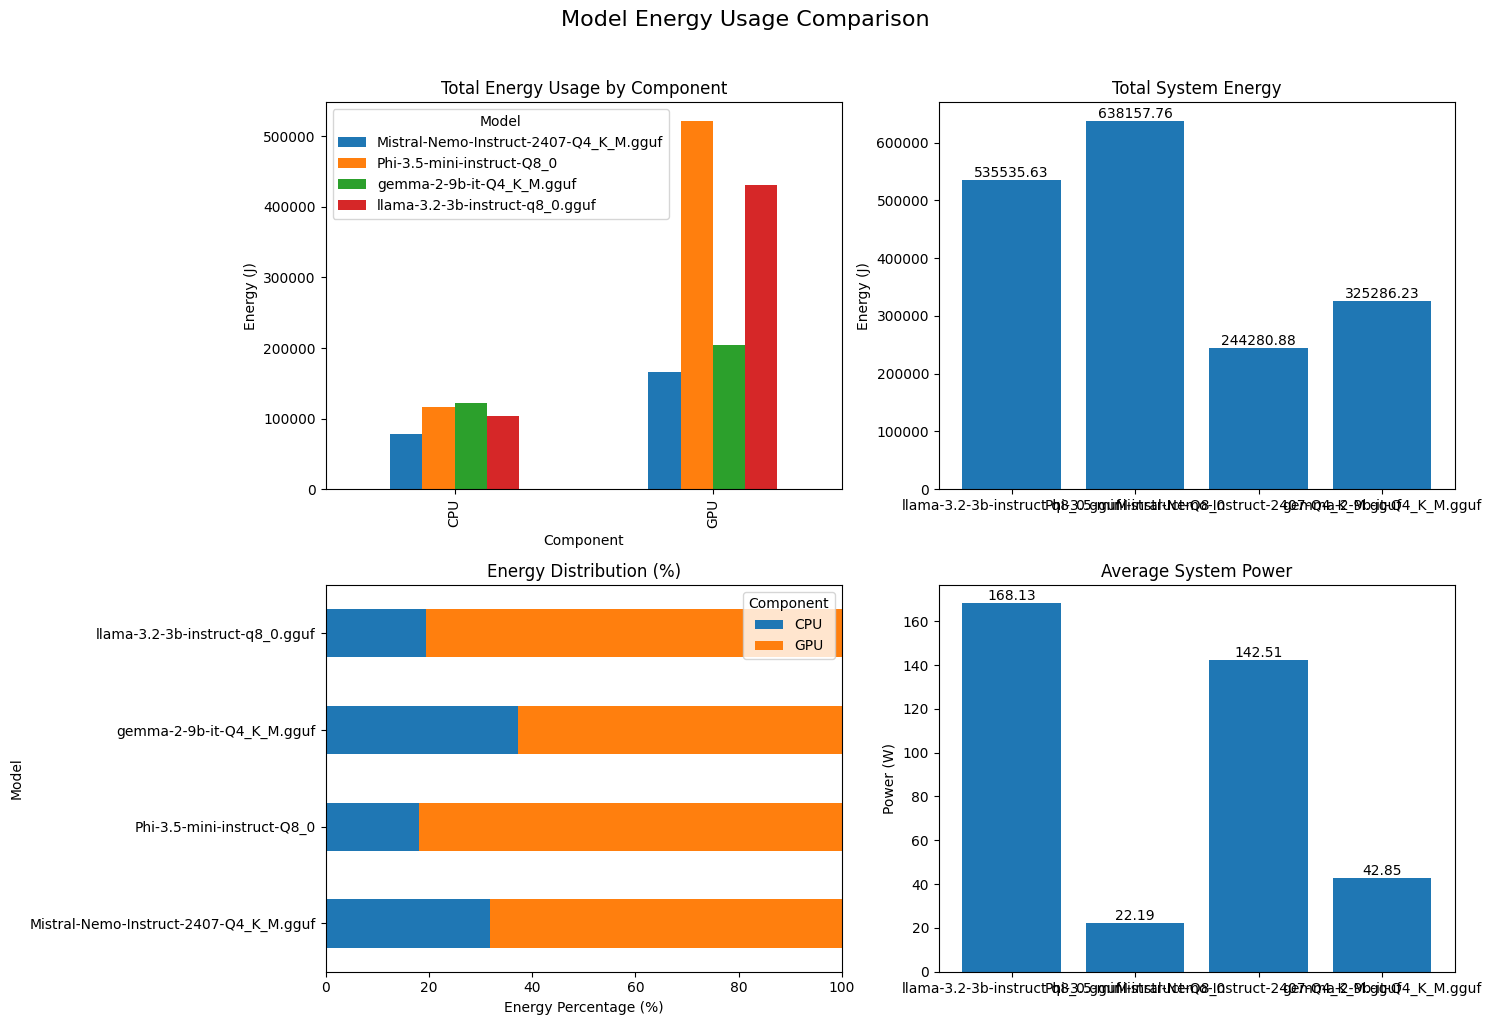

In [ ]:
# Required imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

# List of run IDs to compare
run_ids = [109, 126, 133,134, 130]  # Add your run IDs here

# Collect stats for each run
model_stats = {}
for run_id in run_ids:
    run = Run.get(id=run_id)
    model_stats[run.model_name] = run.get_power_stats_df()

def plot_model_comparisons(model_stats_dict, figsize=(15, 10)):
    """
    Create comparative visualizations of power statistics across different models.
    
    Args:
        model_stats_dict: Dictionary with model names as keys and their stats DataFrames as values
        figsize: Tuple specifying the figure size
    """
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Model Energy Usage Comparison', size=16, y=1.02)
    
    # Color palette
    colors = sns.color_palette("husl", len(model_stats_dict))
    
    # 1. Total Energy by Component
    component_data = []
    for model, df in model_stats_dict.items():
        for _, row in df[df['Component'] != 'System Total'].iterrows():
            component_data.append({
                'Model': model,
                'Component': row['Component'],
                'Total Energy (J)': row['Total Energy (J)']
            })
    comp_df = pd.DataFrame(component_data)
    comp_pivot = comp_df.pivot(index='Component', columns='Model', values='Total Energy (J)')
    comp_pivot.plot(kind='bar', ax=ax1)
    ax1.set_title('Total Energy Usage by Component')
    ax1.set_ylabel('Energy (J)')
    ax1.legend(title='Model')
    
    # 2. System Total Comparison
    system_totals = []
    for model, df in model_stats_dict.items():
        total_row = df[df['Component'] == 'System Total'].iloc[0]
        system_totals.append({
            'Model': model,
            'Total Energy (J)': total_row['Total Energy (J)'],
            'Average Power (W)': total_row['Average Power (W)']
        })
    totals_df = pd.DataFrame(system_totals)
    
    ax2.bar(totals_df['Model'], totals_df['Total Energy (J)'])
    ax2.set_title('Total System Energy')
    ax2.set_ylabel('Energy (J)')
    
    # 3. Energy Distribution
    distribution_data = []
    for model, df in model_stats_dict.items():
        component_data = df[df['Component'] != 'System Total']
        for _, row in component_data.iterrows():
            distribution_data.append({
                'Model': model,
                'Component': row['Component'],
                'Percentage': row['Energy Percentage (%)']
            })
    
    dist_df = pd.DataFrame(distribution_data)
    
    # Plot stacked horizontal bars
    pivot_df = dist_df.pivot(index='Model', columns='Component', values='Percentage')
    pivot_df.plot(kind='barh', stacked=True, ax=ax3)
    
    ax3.set_title('Energy Distribution (%)')
    ax3.set_xlabel('Energy Percentage (%)')
    ax3.legend(title='Component')
    ax3.set_xlim(0, 100)  # Ensure x-axis goes from 0 to 100%
    
    # 4. Average Power Comparison
    ax4.bar(totals_df['Model'], totals_df['Average Power (W)'])
    ax4.set_title('Average System Power')
    ax4.set_ylabel('Power (W)')
    
    # Add value labels on bars for plots 2 and 4
    for ax in [ax2, ax4]:
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f')
    
    plt.tight_layout()
    return fig

# Create the comparison plots
fig = plot_model_comparisons(model_stats)
plt.show()

# You can also save the figure if needed
# fig.savefig('model_comparison.png', dpi=300, bbox_inches='tight')